In [27]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import echopype as ep

In [2]:
data_path = "/Users/wu-jung/code_git/echopype/echopype/test_data/EK80_NEW/echopype-test-D20211004-T235930.raw"

In [3]:
ed = ep.open_raw(data_path, sonar_model="EK80")

11:31:23  parsing file echopype-test-D20211004-T235930.raw, time of first ping: 2021-Oct-04 23:59:30


In [6]:
Sv = ep.calibrate.compute_Sv(ed, waveform_mode="BB", encode_mode="complex")

In [7]:
Sv

<xarray.Dataset>
Dimensions:                (ping_time: 4, channel: 3, range_sample: 750,
                            filenames: 1, time3: 1)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2021-10-04T23:59:30.250...
  * channel                (channel) <U25 'WBT 150013-15 ES120-7C_ES' ... 'WB...
  * range_sample           (range_sample) int64 0 1 2 3 4 ... 746 747 748 749
  * time3                  (time3) datetime64[ns] 2021-10-04T23:59:30.250999808
Dimensions without coordinates: filenames
Data variables: (12/13)
    Sv                     (channel, ping_time, range_sample) float64 nan ......
    echo_range             (channel, ping_time, range_sample) float64 0.0 ......
    frequency_nominal      (channel) float64 1.2e+05 2e+05 7e+04
    temperature            (ping_time) float64 10.0 nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan
    pressure               (ping_time) float64 100.0 nan nan nan
    ...                     ...
    sound_absorption       (ping_time, channel) float64 0.04094 0.05585 ... nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  (channel, ping_time) float64 -20.7 -20.7 ... -20.7
    source_filenames       (filenames) <U96 '/Users/wu-jung/code_git/echopype...
    water_level            (time3) float64 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2022-07-04T18:32:15Z
    processing_function:          calibrate.compute_Sv

In [8]:
def _check_range_uniqueness(da):
    """
    Check if range (``echo_range``) changes across ping in a given frequency channel.
    """
    # squeeze to remove "channel" dim if present
    # TODO: not sure why not already removed for the AZFP case. Investigate.
    da = da.squeeze()

    # remove pings with NaN entries if exist
    # since goal here is to check uniqueness
    if np.unique(da.isnull(), axis=0).shape[0] != 1:
        da = da.dropna(dim="ping_time", how="any")

    # remove padded NaN entries if exist for all pings
    da = da.dropna(dim="range_sample", how="all")

    ping_time_idx = np.argwhere([dim == "ping_time" for dim in da.dims])[0][0]
    if np.unique(da, axis=ping_time_idx).shape[ping_time_idx] == 1:
        return xr.DataArray(data=True, coords={"channel": da["channel"].values})
    else:
        return xr.DataArray(data=False, coords={"channel": da["channel"].values})

In [140]:
ds_Sv = Sv.copy()

In [141]:
range_meter_bin = 20
ping_time_bin = "20S"

In [142]:
if not ds_Sv["echo_range"].groupby("channel").apply(_check_range_uniqueness).all():
    raise ValueError(
        "echo_range variable changes across pings in at least one of the frequency channels."
    )

In [143]:
range_interval = np.arange(0, ds_Sv["echo_range"].max() + range_meter_bin, range_meter_bin)

In [144]:
range_interval

array([ 0., 20.])

In [145]:
ds = ds_Sv.isel(channel=0)

In [146]:
sv = 10 ** (ds["Sv"] / 10).squeeze()  # average should be done in linear domain

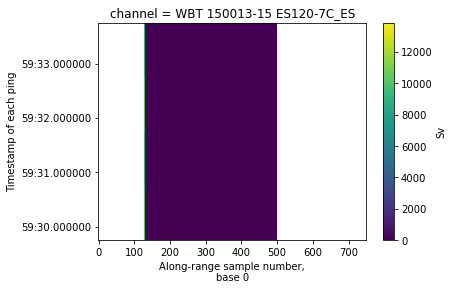

In [147]:
sv.plot()

In [148]:
er = ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time").isel(ping_time=0)

In [149]:
sv = sv.sel(range_sample=er.range_sample.values)

In [151]:
er.range_sample

<xarray.DataArray 'range_sample' (range_sample: 500)>
array([  0,   1,   2, ..., 497, 498, 499])
Coordinates:
    ping_time     datetime64[ns] 2021-10-04T23:59:30.250999808
    channel       <U25 'WBT 150013-15 ES120-7C_ES'
  * range_sample  (range_sample) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Attributes:
    long_name:  Along-range sample number, base 0

In [152]:
sv.coords["echo_range"] = (["range_sample"], er.values)

In [153]:
sv = sv.swap_dims({"range_sample": "echo_range"})

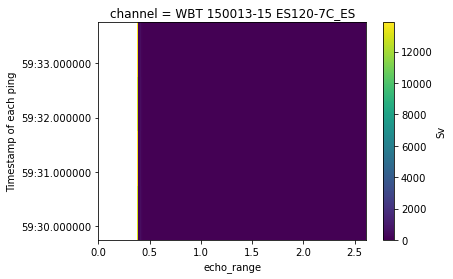

In [154]:
sv.plot()

In [155]:
A = sv.resample(ping_time=ping_time_bin, skipna=True).mean(skipna=True)

In [158]:
A.groupby_bins("echo_range", bins=range_interval, right=False, include_lowest=True).mean(skipna=True)

<xarray.DataArray 'Sv' (ping_time: 1, echo_range_bins: 1)>
array([[67.57070203]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0)
  * ping_time        (ping_time) datetime64[ns] 2021-10-04T23:59:20
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [159]:
(
    sv.resample(ping_time=ping_time_bin, skipna=True)
    .mean(skipna=True)
    .groupby_bins("echo_range", bins=range_interval, right=False, include_lowest=True)
    .mean(skipna=True)
)

<xarray.DataArray 'Sv' (ping_time: 1, echo_range_bins: 1)>
array([[67.57070203]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0)
  * ping_time        (ping_time) datetime64[ns] 2021-10-04T23:59:20
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [102]:
sv_groupby_bins

<xarray.DataArray 'Sv' (ping_time: 1, echo_range_bins: 1)>
array([[nan]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0)
  * ping_time        (ping_time) datetime64[ns] 2021-10-04T23:59:20
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [91]:
sv_groupby_bins.echo_range_bins

<xarray.DataArray 'echo_range_bins' (echo_range_bins: 20)>
array([Interval(0.0, 24.95, closed='left'),
       Interval(24.95, 49.9, closed='left'),
       Interval(49.9, 74.85, closed='left'),
       Interval(74.85, 99.8, closed='left'),
       Interval(99.8, 124.75, closed='left'),
       Interval(124.75, 149.7, closed='left'),
       Interval(149.7, 174.65, closed='left'),
       Interval(174.65, 199.6, closed='left'),
       Interval(199.6, 224.55, closed='left'),
       Interval(224.55, 249.5, closed='left'),
       Interval(249.5, 274.45, closed='left'),
       Interval(274.45, 299.4, closed='left'),
       Interval(299.4, 324.35, closed='left'),
       Interval(324.35, 349.3, closed='left'),
       Interval(349.3, 374.25, closed='left'),
       Interval(374.25, 399.2, closed='left'),
       Interval(399.2, 424.15, closed='left'),
       Interval(424.15, 449.1, closed='left'),
       Interval(449.1, 474.05, closed='left'),
       Interval(474.05, 499.499, closed='left')], dtype=object)
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 24.95) ... [474.05, 499.499)
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [48]:
# set 1D coordinate using the 1st ping echo_range since identical for all pings
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

ValueError: conflicting sizes for dimension 'range_sample': length 500 on 'echo_range' and length 750 on {'ping_time': 'ping_time', 'range_sample': 'range_sample'}

In [40]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

ValueError: conflicting sizes for dimension 'range_sample': length 500 on 'echo_range' and length 373 on {'ping_time': 'ping_time', 'range_sample': 'range_sample'}

In [34]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

IndexError: index 0 is out of bounds for axis 0 with size 0